In [77]:
import cnn
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np
import torch.optim as optim
import utils
import torchvision.transforms as transforms
import torch.nn.functional as F

In [78]:
image_path = '/Users/phamminhtuan/Desktop/AIChallenge/IMG_1581_iter_0.jpg'
label_path = '/Users/phamminhtuan/Desktop/AIChallenge/IMG_1581_iter_0.txt'

In [79]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, label_path):
        """
        Args:
            image_path (str): Path to the input image.
            label_path (str): Path to the label file (YOLO format).
        """
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.inputs, self.targets = [], []
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert image to tensor
            transforms.Resize((28, 28))  # Resize image to 28x28
        ])
        image = cv2.imread(self.image_path)

        # Read label and coordinates
        labels, coords = utils.read_file_to_tensors(self.label_path)

        # Process each coordinate (bounding box)
        for i, coord in enumerate(coords):
            square = utils.find_yolov8_square(image, coord)  # Get bounding box
            cropped_image = utils.get_box(image, square)  # Crop the image
            cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            
            # Apply transformation
            cropped_tensor = self.transform(cropped_image)  # Convert to tensor & resize
            
            self.inputs.append(cropped_tensor)
            self.targets.append(labels[i])  # Append corresponding label

        # Convert inputs and targets to tensors
        
       
    def __getitem__(self, idx):
        image = self.inputs[idx]
        label = self.targets[idx]
        return image, label

    def __len__(self):
        return len(self.inputs)
image_path = '/Users/phamminhtuan/Desktop/AIChallenge/IMG_1581_iter_0.jpg'
label_path = '/Users/phamminhtuan/Desktop/AIChallenge/IMG_1581_iter_0.txt'
train_dataset = MyDataset(image_path, label_path)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.8104403..1.0000001].


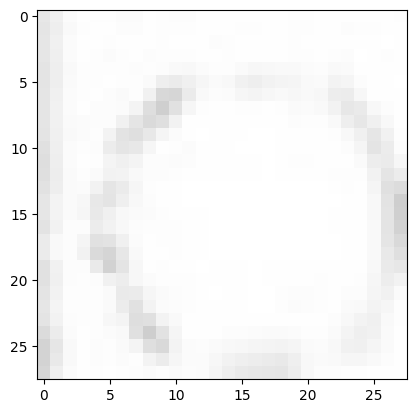

In [92]:
image = train_dataset[0][0].permute(1,2,0)
plt.imshow(image)

In [81]:
len(train_dataset)

571

In [82]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle= True)

In [104]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Input: 3x28x28 -> Output: 16x28x28
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Input: 16x28x28 -> Output: 32x28x28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by 2x
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 14 * 14, 128)  # Flattened size after pooling
        self.fc2 = nn.Linear(128, 2)  # 2 classes (e.g., 0: not filled, 1: filled)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + MaxPooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + MaxPooling
        x = torch.flatten(x, 1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))  # Fully connected layer 1 + ReLU
        x = self.fc2(x)  # Fully connected layer 2 (no activation for logits)
        return x


In [99]:
device = torch.device("mps")
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
epochs = 5
import time

train_img = train_dataset[:][0]
train_label = train_dataset[:][1]

In [105]:
full_loss = []
full_error = []
start = time.time()
num_batches = 0
for epoch in range(epochs):
    model.train()  # Chuyển mô hình sang chế độ huấn luyện
    running_loss = 0
    running_error = 0
    if epoch % 5 == 0:
      lr = lr / 2
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for i in range(0, 571):  # Chia tập dữ liệu thành các batch size = 64
        optimizer.zero_grad()  # Reset gradient
        image = train_img[i]
        target = train_label[i]

        # Forward pass
        output = model(image)
        loss_batch = criterion(output, target)

        # Backward pass và cập nhật trọng số
        loss_batch.backward()
        optimizer.step()

        # Tính tổng loss và error cho toàn bộ epoch
        running_loss += loss_batch.item()
        _, pred = torch.max(output.data, 1)
        running_error += (pred != target).sum().item()
        num_batches += 1
    # Tính giá trị trung bình loss và error
    avg_loss = running_loss / num_batches   # 500 batches
    avg_error = running_error / 794  # Tổng số mẫu là 50000

    # Lưu lại giá trị loss và error
    full_loss.append(avg_loss)
    full_error.append(avg_error)

    # In thông tin về epoch hiện tại
    print(f'Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Error: {avg_error*100:.2f}%')

    # Bạn có thể thêm eval trên tập kiểm tra ở đây nếu muốn

        

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x49 and 1568x128)